In [1]:
import xxzchain as xxz

In [2]:
import numpy as np

In [3]:
S = xxz.load_system('test/lattice21')

Current system loaded by "C:\Users\jeong\master\xxzchain\test\lattice21.hdf5"
Hardcore boson system
Name         : lattice21
Saved path   : C:\Users\jeong\master\xxzchain\C
System size  : 21

Referenced Basis :   (None means full)
	|- Sector [-1 -1  0  0] 
	-----

Defined Operators :
	|- H_fin
	|- H_ini
	|- N
	|- n
	|- nnn
	-----
	Hamiltonian  : -----

Stored Data :
	|- Energy
	|- N_all
	|- N_all_new
	|- n_all
	-----



In [8]:
def partition_f(H,beta):
    return np.exp(-H*beta)

def temper(func, beta):
    def wrapper(x):
        return func(x,beta)
    return wrapper

In [5]:
Energy  = []
N_total = []
n_total = []
for num in range(11): # S = system
    #num = 0
    H_fin         = S.get_operator('H_fin')[num]
    H_ini         = S.get_operator('H_ini')[num]
    n   , N       = S.get_operator("n"), S.get_operator("N")
    initial_basis = S.get_basis(7,0)
    print('initial basis : {} state'.format(len(initial_basis)))
    S.Hamiltonian = H_fin
    print("Hamiltonian : {}".format(S.Hamiltonian.name))

    # get all energy eigenvalues of Nb = 7
    energies = []
    for k in S.range:
        for e in S.get_basis(7,k).energy:
            energies.append(e)
    assert len(energies) == len(S.get_basis(7))
    energies = np.array(energies)
    Energy.append(energies)

Initializing spin conserving sectors of given basis : (-1,-1,0,0)
Initializing momentum sectors of given basis : (7,-1,0,0)
initial basis : 5538 state
Hamiltonian : H_fin.0
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializi

In [6]:
S.save('Energy',Energy)

In [7]:
S.tree

Hardcore boson system
Name         : lattice21
Saved path   : C:\Users\jeong\master\xxzchain\C
System size  : 21

Referenced Basis :   (None means full)
	|- Sector [ 7 -1  0  0] 
	-----

Defined Operators :
	|- H_fin
	|- H_ini
	|- N
	|- n
	|- nnn
	-----
	Hamiltonian  : 'H_fin.0.48'

Stored Data :
	|- Energy
	-----



### n, N diag values

In [8]:
n_all = [[[] for k in S.range] for i in range(11)]
N_all = [[[] for k in S.range] for i in range(11)]
Hfins = S.get_operator('H_fin')
for k, O in enumerate(zip(n,N)):
    nk, Nk = O #unpack n, N
    for kk in S.range:
        target_basis = S.get_basis(7,kk)
        nk_mat = nk.get_matrix(target_basis)
        Nk_mat = Nk.get_matrix(target_basis)
        for i, Hfin in enumerate(Hfins):
            print(k,kk,i)
        #if not kk: continue
            c_mat = Hfin.get_eigenvectors(target_basis)
            nk_aa = ((c_mat.conjugate().T@nk_mat)*c_mat.T).sum(axis=1).real
            Nk_aa = ((c_mat.conjugate().T@Nk_mat)*c_mat.T).sum(axis=1).real
            for v in list(nk_aa):
                n_all[i][k].append(v)
            for v in list(Nk_aa):
                N_all[i][k].append(v)
#N_total.append(N_all)
#n_total.append(n_all)

In [8]:
#S.save('n_all', n_all)
S.save('N_all_new', N_all)

In [4]:
N_all = S.get_data('N_all_new')

In [5]:
n_all = S.get_data("n_all")

In [10]:
n_all = np.array(n_all)

In [11]:
N_all = np.array(N_all)

In [6]:
Energy = S.get_data('Energy')

In [9]:
target_E = []
# eff T = 2.0, 3.0
for beta in [1/2, 1/3]:
    partition = temper(partition_f, beta)            # exp(-beta H)
    Z         = partition(Energy).sum(axis=1)            # sum   exp(-beta E)
    E_        = (Energy*partition(Energy)).sum(axis=1)/Z # sum E*exp(-beta E)/Z
    target_E.append(E_)
target_E = np.array(target_E)

In [12]:
n_all.shape

(11, 21, 116280)

In [10]:
coef = [0]
for i in range(5):
    coef.append(0.02*2**i)
    coef.append(0.03*2**i)

In [11]:
Co = {}
for i, c in enumerate(coef):
    Co[c] = i

In [15]:
dE = 0.1
microC = []
for i in range(11):
    temp = []
    for k in S.range:
        
        temp.append((np.average(n_all[i][k][np.logical_and(Energy[i]<target_E[0][i]+dE,Energy[i]>target_E[0][i]-dE)]),np.average(n_all[i][k][np.logical_and(Energy[i]<target_E[1][i]+dE,Energy[i]>target_E[1][i]-dE)])))
    microC.append(temp)

#find proper initial eigenstate


states = []
initial_basis = S.get_basis(7,0)
for fin,ini in zip(S.get_operator("H_fin"),S.get_operator("H_ini")):
    #print(fin.name[5:] == ini.name[5:])
    states.append(fin.expectation(ini.get_eigenstates(initial_basis)))
states = np.array(states)

index = -1*np.ones([2,11], dtype = np.int32)
De = 10*np.ones([2,11])
Ei = np.zeros([2,11])
for i, e in enumerate(states.T):
    
    index[np.abs(e-target_E)<De] = i
    #Ei   [np.abs(e-target_E)<De] = e.real
    De   [np.abs(e-target_E)<De] = np.abs(e-target_E)[np.abs(e-target_E)<De]


assert not (index == -1).any()

### FiG3

In [201]:
target_E = []
# eff T = 2.0, 3.0
for beta in [1/2,1/3]:
    partition = temper(partition_f, beta)            # exp(-beta H)
    Z         = partition(Energy).sum(axis=1)            # sum   exp(-beta E)
    E_        = (Energy*partition(Energy)).sum(axis=1)/Z # sum E*exp(-beta E)/Z
    target_E.append(E_)
target_E = np.array(target_E)

In [202]:
index = -1*np.ones([2,11], dtype = np.int32)
De = 10*np.ones([2,11])
Ei = np.zeros([2,11])
for i, e in enumerate(states.T):
    
    index[np.abs(e-target_E)<De] = i
    #Ei   [np.abs(e-target_E)<De] = e.real
    De   [np.abs(e-target_E)<De] = np.abs(e-target_E)[np.abs(e-target_E)<De]

In [203]:
index

array([[ 247,  646,  279,  261,  105,  216,  113,  172,  109,  108,   67],
       [ 567,  562,  406,  553,  556,  447, 1038,  595,  539,  451,  332]])

In [ ]:
xxz.State.time_evolving_states()

In [23]:
n_diag  , N_diag   = [], []
twoini_n, twoini_N = [], []
delta_n , delta_N  = [], []
n       , N        = S.get_operator('n'), S.get_operator('N') 
for k in S.range:
    nk, Nk  = n[k].get_matrix(initial_basis), N[k].get_matrix(initial_basis)
    temp1, temp2 = [],[]
    exp1 , exp2  = [],[]
    TEn  , TEN   = [],[]
    
    for i in range(11):
        print(i,k)
        Hi = S.get_operator("H_ini")[i]
        S.Hamiltonian = S.get_operator("H_fin")[i]
        initial = Hi.get_eigenstates(S.get_basis(7,0))[index.T[i]]
        TE = initial[1].time_evolving_states(np.arange(251)/250)
        Casq = (initial.eigencoef)*(initial.eigencoef.conjugate())
        temp1.append(Casq.T@n_all[i][k][:len(initial.basis)])
        temp2.append(Casq.T@N_all[i][k][:len(initial.basis)])
        exp1.append((initial.coef.conjugate().T@nk@initial.coef)[np.diag_indices(len(initial))])
        exp2.append((initial.coef.conjugate().T@Nk@initial.coef)[np.diag_indices(len(initial))])
        TEn.append((TE.coef.conjugate().T@nk@TE.coef)[np.diag_indices(251)])
        TEN.append((TE.coef.conjugate().T@Nk@TE.coef)[np.diag_indices(251)])
    n_diag.append(temp1)
    N_diag.append(temp2)
    twoini_n.append(exp1)
    twoini_N.append(exp2)        
    delta_n.append(TEn)
    delta_N.append(TEN)

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
10 2
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
10 3
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
10 4
0 5
1 5
2 5
3 5
4 5
5 5
6 5
7 5
8 5
9 5
10 5
0 6
1 6
2 6
3 6
4 6
5 6
6 6
7 6
8 6
9 6
10 6
0 7
1 7
2 7
3 7
4 7
5 7
6 7
7 7
8 7
9 7
10 7
0 8
1 8
2 8
3 8
4 8
5 8
6 8
7 8
8 8
9 8
10 8
0 9
1 9
2 9
3 9
4 9
5 9
6 9
7 9
8 9
9 9
10 9
0 10
1 10
2 10
3 10
4 10
5 10
6 10
7 10
8 10
9 10
10 10
0 11
1 11
2 11
3 11
4 11
5 11
6 11
7 11
8 11
9 11
10 11
0 12
1 12
2 12
3 12
4 12
5 12
6 12
7 12
8 12
9 12
10 12
0 13
1 13
2 13
3 13
4 13
5 13
6 13
7 13
8 13
9 13
10 13
0 14
1 14
2 14
3 14
4 14
5 14
6 14
7 14
8 14
9 14
10 14
0 15
1 15
2 15
3 15
4 15
5 15
6 15
7 15
8 15
9 15
10 15
0 16
1 16
2 16
3 16
4 16
5 16
6 16
7 16
8 16
9 16
10 16
0 17
1 17
2 17
3 17
4 17
5 17
6 17
7 17
8 17
9 17
10 17
0 18
1 18
2 18
3 18
4 18
5 18
6 18
7 18
8 18
9 18
10 18
0 19
1 19
2 19
3 19
4 19
5 19
6 19
7 19
8 19
9

In [155]:
n_diag  = np.array(n_diag)
N_diag  = np.array(N_diag)
twoini_n  = np.array(twoini_n)
twoini_N  = np.array(twoini_N)
delta_n  = np.array(delta_n)
delta_N  = np.array(delta_N)

In [50]:
n_diag = np.swapaxes(n_diag, 0,1)
N_diag = np.swapaxes(N_diag, 0,1)
twoini_n  =np.swapaxes(twoini_n, 0,1)
twoini_N  =np.swapaxes(twoini_N, 0,1)
delta_n  =np.swapaxes(delta_n, 0,1)
delta_N  =np.swapaxes(delta_N, 0,1)

In [31]:
import matplotlib.pyplot as plt

In [167]:
len(initial)

99

In [160]:
n_all.shape

(11, 21, 116280)

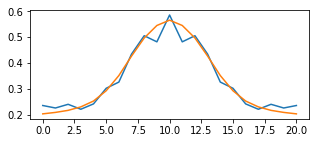

In [214]:
plt.figure(figsize=[5,2])
#plt.plot(np.roll(twoini_n[Co[0.24]].T[0],10))
plt.plot(np.roll(twoini_n[Co[0.24]].T[1],10))
plt.plot(np.roll(n_diag[Co[0.24]].T[1],10))

(0, 0.4)

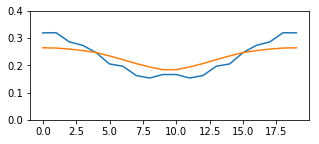

In [218]:
plt.figure(figsize=[5,2])
#plt.plot(np.roll(twoini_n[Co[0.24]].T[0],10))
plt.plot(np.roll(twoini_N[Co[0.24]].T[1][1:],10))
plt.plot(np.roll(N_diag[Co[0.24]].T[1][1:],10))
plt.ylim([0,0.4])

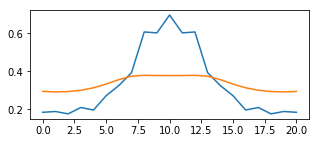

In [161]:
plt.figure(figsize=[5,2])
#plt.plot(np.roll(twoini_n[Co[0.24]].T[0],10))
plt.plot(np.roll(twoini_n[Co[0.24]].T[0],10))
plt.plot(np.roll(n_diag[Co[0.24]].T[0],10))

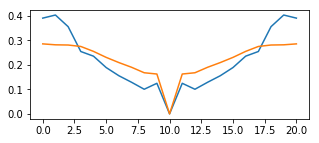

In [80]:
plt.figure(figsize=[5,2])
#plt.plot(np.roll(twoini_n[Co[0.24]].T[0],10))
plt.plot(np.roll(twoini_N[Co[0.24]].T[0],10))
plt.plot(np.roll(N_diag[Co[0.24]].T[0],10))

In [54]:
n_diag.T[1].T.shape

(11, 21)

In [219]:
diff_two_n = np.abs(twoini_n-n_diag).sum(axis = 1)/n_diag.sum(axis=1)

In [220]:
diff_two_N = np.abs(twoini_N-N_diag).sum(axis = 1)/N_diag.sum(axis=1)

In [93]:
diff_two_n

array([[0.09026086+0.j, 0.10436389+0.j],
       [0.1386455 +0.j, 0.08331816+0.j],
       [0.09581575+0.j, 0.10630463+0.j],
       [0.09748861+0.j, 0.05809077+0.j],
       [0.1367705 +0.j, 0.09442513+0.j],
       [0.09992854+0.j, 0.08647479+0.j],
       [0.12191313+0.j, 0.06171889+0.j],
       [0.13563766+0.j, 0.05352638+0.j],
       [0.09277923+0.j, 0.0564453 +0.j],
       [0.10271319+0.j, 0.07199879+0.j],
       [0.09210585+0.j, 0.10687462+0.j]])

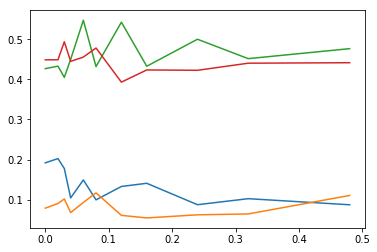

In [224]:
plt.plot(coef, diff_two_n)
plt.plot(coef, diff_two_N)

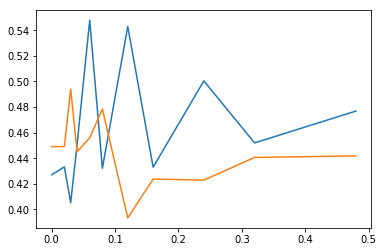

In [223]:
plt.plot(coef, diff_two_N)

In [173]:
n_diag[Co[0.24]].T[1]

array([0.44835129+0.j, 0.44489475+0.j, 0.43006472+0.j, 0.39969588+0.j,
       0.3584845 +0.j, 0.31836453+0.j, 0.2866732 +0.j, 0.26827694+0.j,
       0.25840659+0.j, 0.25589675+0.j, 0.2550665 +0.j, 0.2550665 +0.j,
       0.25589675+0.j, 0.25840659+0.j, 0.26827694+0.j, 0.2866732 +0.j,
       0.31836453+0.j, 0.3584845 +0.j, 0.39969588+0.j, 0.43006472+0.j,
       0.44489475+0.j])

In [189]:
index[5]

array([173, 162, 159,  75, 158,  57, 111, 119,  52,  68,  38])

In [204]:
n_diag  , N_diag   = [], []
S.Hamiltonian = None
for i, ini in enumerate(S.get_operator("H_ini")):
    initial = ini.get_eigenstates(S.get_basis(7,0))[index.T[i]]
    S.Hamiltonian = S.get_operator("H_fin")[i]
    for k in S.range:
        Casq = (initial.eigencoef)*(initial.eigencoef.conjugate())
        temp1.append(Casq.T@n_all[i][k][:len(initial.basis)])
        temp2.append(Casq.T@N_all[i][k][:len(initial.basis)])
    n_diag.append(temp1)
    N_diag.append(temp2)

In [94]:
dE = 0.1
n_microC, N_microC = [], []
for i in range(11):
    temp1,temp2 = [],[]
    for k in S.range:
        temp1.append((np.average(n_all[i][k][np.logical_and(Energy[i]<target_E[0][i]+dE,Energy[i]>target_E[0][i]-dE)]),np.average(n_all[i][k][np.logical_and(Energy[i]<target_E[1][i]+dE,Energy[i]>target_E[1][i]-dE)])))
        temp2.append((np.average(N_all[i][k][np.logical_and(Energy[i]<target_E[0][i]+dE,Energy[i]>target_E[0][i]-dE)]),np.average(N_all[i][k][np.logical_and(Energy[i]<target_E[1][i]+dE,Energy[i]>target_E[1][i]-dE)])))
    n_microC.append(temp1)
    N_microC.append(temp2)

In [95]:
n_microC = np.array(n_microC)

In [96]:
N_microC = np.array(N_microC)

In [109]:
N_microC = np.swapaxes(N_microC,0,1)

In [110]:
diff_DMn = np.abs(n_microC-n_diag).sum(axis = 1)/n_diag.sum(axis=1)
diff_DMN = np.abs(N_microC-N_diag).sum(axis = 1)/N_diag.sum(axis=1)

C:\Users\jeong\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


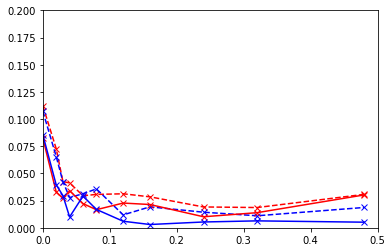

In [196]:
plt.plot(coef, diff_DMn.T[0],'rx--')
plt.plot(coef, diff_DMn.T[1],'bx--')
plt.plot(coef, diff_DMN.T[0],'rx-')
plt.plot(coef, diff_DMN.T[1],'bx-')
plt.xlim([0,0.5])
plt.ylim([0,0.2])
plt.savefig('fig3.png')

In [150]:
target_E = []
# eff T = 2.0, 3.0
for beta in np.arange(0.1,10,0.1):
    partition = temper(partition_f, beta)            # exp(-beta H)
    Z         = partition(Energy).sum(axis=1)            # sum   exp(-beta E)
    E_        = (Energy*partition(Energy)).sum(axis=1)/Z # sum E*exp(-beta E)/Z
    target_E.append(E_)
target_E = np.array(target_E)

In [115]:
target_E.shape

(99, 11)

In [151]:
dE = 0.1
'''states = []
initial_basis = S.get_basis(7,0)
for fin,ini in zip(S.get_operator("H_fin"),S.get_operator("H_ini")):
    #print(fin.name[5:] == ini.name[5:])
    states.append(fin.expectation(ini.get_eigenstates(initial_basis)))
states = np.array(states)'''

index = -1*np.ones([99,11], dtype = np.int32)
De = 10*np.ones([99,11])
Ei = np.zeros([99,11])
for i, e in enumerate(states.T):
    
    index[np.abs(e-target_E)<De] = i
    #Ei   [np.abs(e-target_E)<De] = e.real
    De   [np.abs(e-target_E)<De] = np.abs(e-target_E)[np.abs(e-target_E)<De]


assert not (index == -1).any()

In [153]:
De.max()

1.140057733291707

In [123]:
np.arange(5538)[index.T[0]]

array([   0,    0,    0,    0,    1,    1,    1,    2,    4,    6,   11,
         14,   87,  116,  128,   59,  540,  236,  246,  247,  118,  328,
        920,  952,  473,  478,  483, 1168,  531,  567,  240,  572,  274,
       1415, 1333,  368,  300,  727,  708,  729, 1397, 1591, 1494,  777,
        468,  903, 1755, 1607, 1617,  922,  872, 1630,  871, 1772, 2892,
       2894, 1812,  962, 1674, 1071, 1095, 1102, 1082, 1107,  985, 1799,
        936,  890, 1920, 1989, 1897, 1142, 1958, 1206, 1188, 1933, 2987,
       1278,  607, 2185, 1952, 1220, 1248, 1197, 1977, 1088, 3224, 1251,
       1950,  693, 2061, 2075, 1970, 2067, 2099, 3086, 2122, 2034, 1305])

In [127]:
S.get_operator("H_ini")[0].get_operator

'H_ini.0'

In [208]:
n_diag  , N_diag   = [], []

for i, ini in enumerate(S.get_operator("H_ini")):
    initial = ini.get_eigenstates(initial_basis)[index.T[i]]
    S.Hamiltonian = S.get_operator("H_fin")[i]
    temp1,temp2 = [],[]
    Casq = (initial.eigencoef)*(initial.eigencoef.conjugate())
    for k in S.range:
        temp1.append(Casq.T@n_all[i][k][:len(initial.basis)])
        temp2.append(Casq.T@N_all[i][k][:len(initial.basis)])
    n_diag.append(temp1)
    N_diag.append(temp2)

In [209]:
n_diag = np.array(n_diag)

In [210]:
N_diag = np.array(N_diag)

In [211]:
n_diag.shape

(11, 21, 2)

In [147]:
dE = 0.1
n_microC, N_microC = [], []
for i in range(11):
    temp1,temp2 = [],[]
    for k in S.range:
        kt1, kt2 = [],[]
        for j in range(target_E.shape[0]):
            if len(n_all[i][k][np.logical_and(Energy[i]<target_E[j][i]+dE,Energy[i]>target_E[j][i]-dE)]) == 0:
                kt1.append(float('inf'))
            else:
                kt1.append((np.average(n_all[i][k][np.logical_and(Energy[i]<target_E[j][i]+dE,Energy[i]>target_E[j][i]-dE)])))
            if len(N_all[i][k][np.logical_and(Energy[i]<target_E[j][i]+dE,Energy[i]>target_E[j][i]-dE)]) == 0:
                kt2.append(float('inf'))
            else:
                kt2.append((np.average(N_all[i][k][np.logical_and(Energy[i]<target_E[j][i]+dE,Energy[i]>target_E[j][i]-dE)])))
        temp1.append(kt1)
        temp2.append(kt2)
    n_microC.append(temp1)
    N_microC.append(temp2)

In [149]:
n_microC = np.array(n_microC)
N_microC = np.array(N_microC)

In [155]:
index

array([[ 247,  646,  279,  261,  105,  216,  113,  172,  109,  108,   67],
       [ 567,  562,  406,  553,  556,  447, 1038,  595,  539,  451,  332]])

In [164]:
5000*20

100000

In [ ]:
microC = np.array(microC)

In [ ]:
two_ini = np.array(two_ini)

In [133]:
n_diag.shape

(11, 21, 2)

In [145]:
microC.shape

(11, 21, 2)

In [200]:
diff_DM = np.abs(n_microC-n_diag).sum(axis = 1)/n_diag.sum(axis=1)
    

ValueError: operands could not be broadcast together with shapes (11,21,99) (0,) 

In [198]:
diff_DM.T

NameError: name 'diff_DM' is not defined

In [197]:
plt.plot(coef, diff_DM.T[0],'rx--')
plt.plot(coef, diff_DM.T[1],'bx--')
plt.xlim([0,0.5])
plt.ylim([0,0.2])

NameError: name 'diff_DM' is not defined

In [48]:
target_E.shape

(2, 11)

In [49]:
target_E 

array([[-5.17473959, -5.22553864, -5.25246384, -5.280407  , -5.33934908,
        -5.40236728, -5.54063143, -5.69517767, -6.0528633 , -6.47458556,
        -7.50419061],
       [-3.40293368, -3.42471133, -3.43666639, -3.44933381, -3.47681009,
        -3.50714855, -3.57644225, -3.65726914, -3.85368697, -4.09662288,
        -4.72204121]])

In [51]:
index

array([[ 247,  646,  279,  261,  105,  216,  113,  172,  109,  108,   67],
       [ 567,  562,  406,  553,  556,  447, 1038,  595,  539,  451,  332]])

In [16]:
Ei = De +target_E

In [17]:
Ei

array([[-5.16653095, -5.22352668, -5.24618259, -5.27737169, -5.33596957,
        -5.40186148, -5.53986784, -5.69492937, -6.05022825, -6.47033266,
        -7.44462663],
       [-3.39880055, -3.42341822, -3.43517415, -3.4446234 , -3.47511264,
        -3.50271176, -3.57628828, -3.65726862, -3.85310818, -4.09583827,
        -4.71653009]])

In [ ]:
print('eff_T   : {}, <U>    : {}'.format([2,3],target_E))
print('initial : {}, energy : {}, Delta E : {}'.format(index, Ei, De) )

#set initial state (T = 2.0, T = 3.0)
initial_state = H_ini.get_eigenstates(initial_basis)[index]

In [190]:
index

array([[2308, 1327, 1963, ..., 1932, 1830, 1659],
       [ 922, 2821,  957, ...,  960,  999,  997],
       [ 306,  624, 1142, ...,  674,  494,  463],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]])

In [53]:
initial_states = []
S.Hamiltonian = None
for ini,ind in zip(S.get_operator("H_ini"), index.T):
    initial_states.append(ini.get_eigenstates(initial_basis)[ind])

In [69]:
n_all.shape

(11, 21, 116280)

In [91]:
n_all[0][0][:5538][n_all[0][0][:5538] == n_all[0][16][:5538]].shape

(5538,)

In [82]:
n_all.shape

(11, 21, 116280)

In [83]:
N_all.shape

(11, 21, 116280)

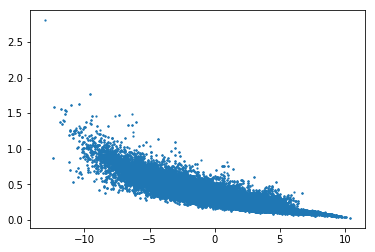

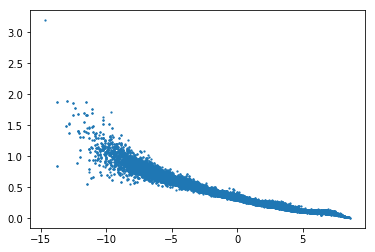

In [108]:
for i in [2,-3]:
    plt.figure()
    plt.scatter(Energy[i], N_all[i][0],s = 1.5)

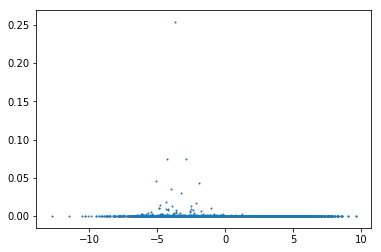

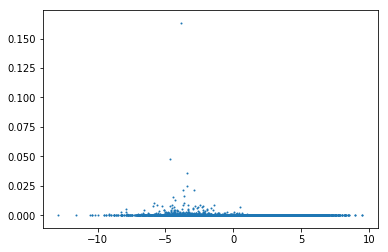

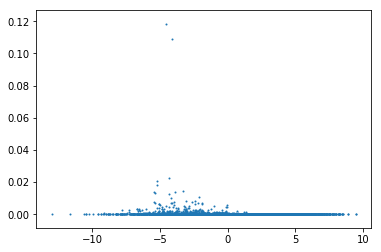

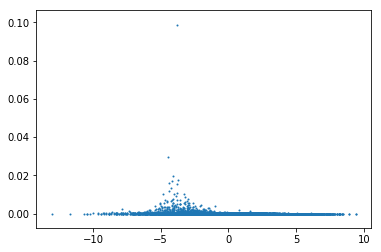

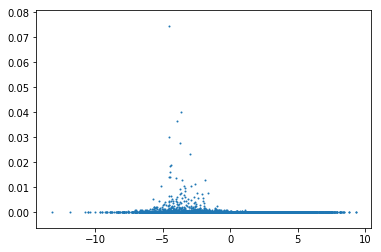

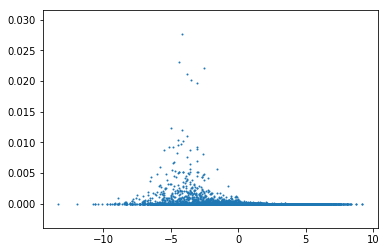

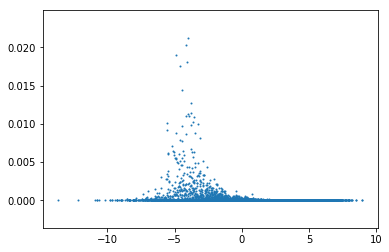

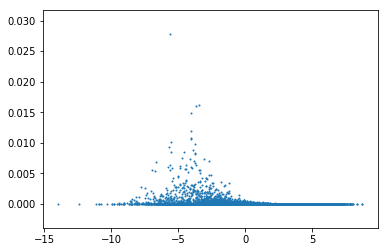

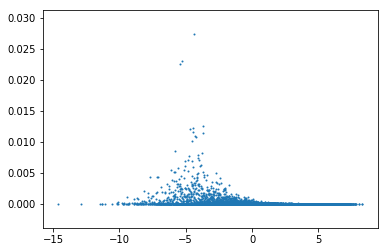

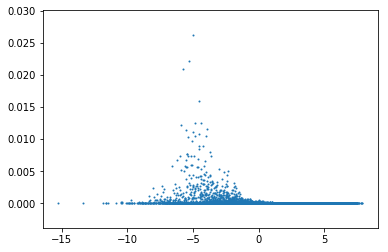

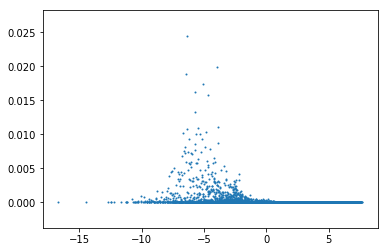

In [90]:
n_diag, N_diag = [],[]
n_val, N_val = [],[]
n_can, N_can = [],[]
n_micro, N_micro =[],[]
for i, arg in enumerate(zip(S.get_operator("H_fin"),S.get_operator("H_ini"), index.T)):
    fin, ini,ind = arg
    S.Hamiltonian = None
    initial_state =ini.get_eigenstates(initial_basis)[ind]
    S.Hamiltonian = fin
    temp = [[],[]]
    plt.figure()
    plt.scatter(Energy[i][:5538],(initial_state.eigencoef*initial_state.eigencoef.conjugate()).T[1],s = 1)
    for k in S.range:
        temp[0].append((initial_state.eigencoef*initial_state.eigencoef.conjugate()).T@n_all[i][k][:len(initial_basis)])
        temp[1].append((initial_state.eigencoef*initial_state.eigencoef.conjugate()).T@N_all[i][k][:len(initial_basis)])
    n_diag.append(temp[0])
    N_diag.append(temp[1])
    
    

In [20]:
import matplotlib.pyplot as plt

In [102]:
n_diag = np.array(n_diag)
N_diag = np.array(N_diag)

In [72]:
n_diag.shape

(11, 21, 2)

In [31]:
S.data_list()

/data : dir
	Energy
	N_all
	n_all


In [27]:
S.data_list

array([[0.63558997+0.j, 0.5478449 +0.j],
       [0.66456603+0.j, 0.53918354+0.j],
       [0.54620845+0.j, 0.47495582+0.j],
       [0.42449893+0.j, 0.40155496+0.j],
       [0.34876821+0.j, 0.33246038+0.j],
       [0.25712774+0.j, 0.28630606+0.j],
       [0.20088684+0.j, 0.25598752+0.j],
       [0.18595412+0.j, 0.23963922+0.j],
       [0.19147085+0.j, 0.22309267+0.j],
       [0.16915248+0.j, 0.22718424+0.j],
       [0.19357135+0.j, 0.24571312+0.j],
       [0.19357135+0.j, 0.24571312+0.j],
       [0.16915248+0.j, 0.22718424+0.j],
       [0.19147085+0.j, 0.22309267+0.j],
       [0.18595412+0.j, 0.23963922+0.j],
       [0.20088684+0.j, 0.25598752+0.j],
       [0.25712774+0.j, 0.28630606+0.j],
       [0.34876821+0.j, 0.33246038+0.j],
       [0.42449893+0.j, 0.40155496+0.j],
       [0.54620845+0.j, 0.47495582+0.j],
       [0.66456603+0.j, 0.53918354+0.j]])

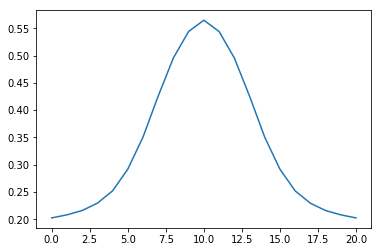

In [213]:
plt.plot(np.roll(n_diag[8].T[1],10))